In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import matplotlib.colors as colors

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view 

import tqdm
import collections
try:
    import cPickle as pickle
except:
    import pickle

import setigen as stg
import blscint as bls
from blscint.observations.organization import DSFile, DSPointing, DSCadence
from blscint.remote import dsc_cadence 

import scipy.special
import scipy.stats
from astropy.stats import sigma_clip

from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord

import abc
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore")

import sklearn.metrics 
import sqlite3

import jort
import os
import copy
import shutil
import psutil
from pathlib import Path
import contextlib
import subprocess

from KDEpy import FFTKDE

import sys 
sys.path.insert(0, '../brkl-111_dedoppler_pipeline')
import survey_direction_filter as sdf

DATA_DIR = Path("/datax2/users/bryanb")
DB_PATH = DATA_DIR / "pipeline.sqlite3"
DIAGSTAT_DIR = DATA_DIR / "scintillation_diagstats"
FIGURES_DIR = Path("/home/bryanb/scintillation_project/scintillation_search_paper/scintillation-search-paper/figures/")

model_frame = stg.Frame.from_backend_params(fchans=256, 
                                            obs_length=600,
                                            int_factor=7)
model_frame.get_params()

{'fchans': 256,
 'tchans': 239,
 'df': 2.7939677238464355,
 'dt': 2.505397589333333,
 'fch1': 6000000000.0,
 'ascending': False}

In [2]:
%matplotlib inline

In [3]:
tr = jort.Tracker()
tr.start('load cadences')
with open('../scintillation_search_paper/full_processed_cadences.pickle', 'rb') as f:
    cadence_list = pickle.load(f)
tr.stop()
tr.report()

_, NGP_pointings = sdf.construct_cadence_list(sdf.nested_target_list)

hits_dfs = []
events_dfs = []
partial_events_dfs = []
for c in cadence_list:
    events_dfs.append(c.events)
    partial_events_dfs.append(c.partial_events)
    for p in c:
        # hits_df = p.hits[p.hits['node']=='blc61']
        hits_df = p.hits
        hits_dfs.append(hits_df)
df_hits = pd.concat(hits_dfs)
df_events = pd.concat(events_dfs)
df_partial_events = pd.concat(partial_events_dfs)
print(df_hits.shape)
print(df_events.shape)
print(df_partial_events.shape)
df_hits.head()

load cadences.stop INFO     Elapsed time: 305.1 s

Session: None
load cadences | 305.1 s ± 0.0 s per iteration, n = 1

Completed session 0 (1 of 5)
Completed session 1 (2 of 5)
Completed session 2 (3 of 5)
Completed session 3 (4 of 5)
Completed session 4 (5 of 5)
(1277325, 610)
(12036, 613)
(106096, 613)


,TopHitNum,DriftRate,SNR,Uncorrected_Frequency,Corrected_Frequency,ChanIndx,FreqStart,FreqEnd,SEFD,SEFD_freq,...,num_hits_rfi_DIAG_SCINT_GC_C10_0028,idx_hits_rfi_DIAG_SCINT_GC_C10_0028,num_hits_DIAG_SCINT_GC_C12_0029,idx_hits_DIAG_SCINT_GC_C12_0029,num_hits_rfi_DIAG_SCINT_GC_C12_0029,idx_hits_rfi_DIAG_SCINT_GC_C12_0029,num_hits_DIAG_SCINT_GC_C10_0026,idx_hits_DIAG_SCINT_GC_C10_0026,num_hits_rfi_DIAG_SCINT_GC_C10_0026,idx_hits_rfi_DIAG_SCINT_GC_C10_0026
0,1,0.126824,10.069126,8438.699626,8438.699626,94925,8438.712406,8438.686850,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,-0.004373,142.755524,8438.500000,8438.500000,166374,8438.512780,8438.487223,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.100585,395.154938,8438.399719,8438.399719,202266,8438.412499,8438.386942,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0.056852,3406.843262,8438.099815,8438.099815,309606,8438.112594,8438.087038,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0.104958,311.695190,8437.987648,8437.987648,349752,8438.000428,8437.974871,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
t_ds = [10, 30, 100]
dfs = [pd.read_csv(f"../brkl-141_joint_diagstat_distribution/synthetic-t_d{t_d}-snr33-n1e4.diagstat.csv") 
       for t_d in t_ds]
kderanker_1e4 = bls.KDERanker(t_ds, dfs, bw_adjust=1)

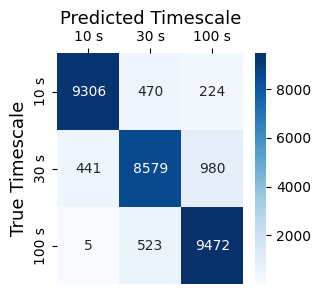

<Figure size 1200x1200 with 0 Axes>

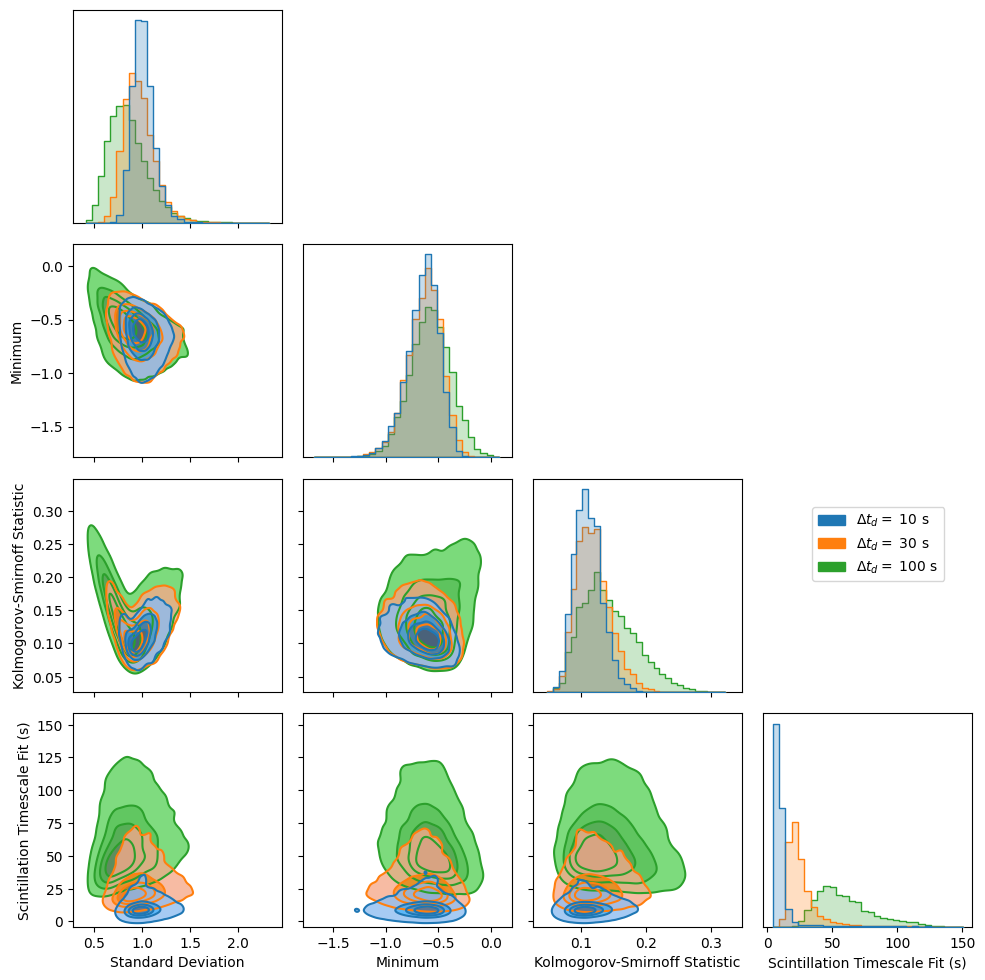

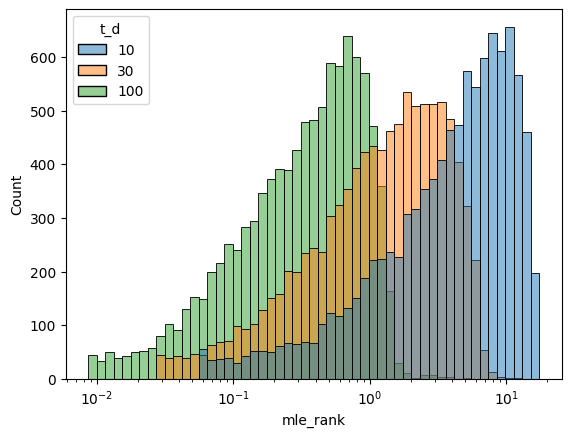

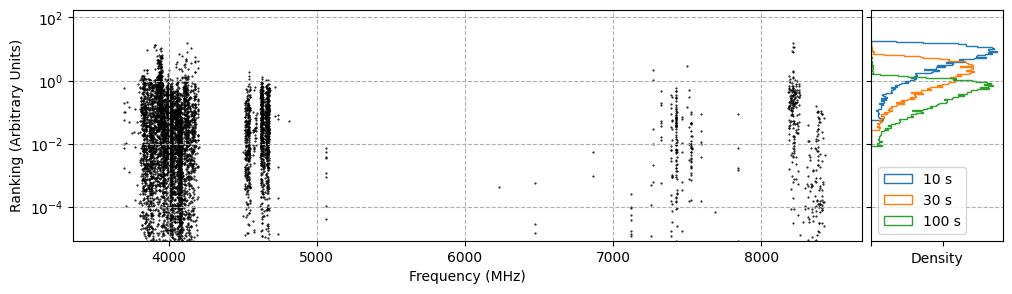

In [5]:
fig = plt.figure(figsize=(3, 3))
kderanker_1e4.plot_confusion_matrix()
plt.savefig('kdeplots/confusion_0.pdf', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(12, 12))
kderanker_1e4.plot_diagstat_corner_plot(bw_adjust=1)
plt.savefig('kdeplots/corner_0.pdf', bbox_inches='tight')
plt.show()

kderanker_1e4.plot_synthetic_ranks()
plt.savefig('kdeplots/ranking_0.pdf', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(12, 3))
kderanker_1e4.plot_ranking_vs_frequency(df_events)
plt.savefig('kdeplots/ranking_frequency_0.pdf', bbox_inches='tight')
plt.show()

In [10]:
df_events['mle_rank'] = df_events.apply(lambda row: kderanker_1e4.rank(row)[0], axis=1)
df_events['mle_t_d'] = df_events.apply(lambda row: kderanker_1e4.rank(row)[1], axis=1)

In [13]:
new_df_view = df_events[df_events['Uncorrected_Frequency']<8000].sort_values('mle_rank', ascending=False)[['TopHitNum', 'Uncorrected_Frequency', 'node', 'target_event_idx', 'found_with', 'fchans', 'std', 'min', 'ks', 'fit_t_d', 'mle_rank', 'mle_t_d']]
new_df_view=new_df_view.reset_index()
new_df_view.head(10)

,index,TopHitNum,Uncorrected_Frequency,node,target_event_idx,found_with,fchans,std,min,ks,fit_t_d,mle_rank,mle_t_d
0,5688,15,4124.925317,blc65,DIAG_SCINT_GP_L5_B0_0012,A0,256,0.927501,-0.543055,0.093419,7.543110,15.053058,10
1,9904,689,3909.042444,blc76,DIAG_SCINT_GP_L1_B1_0036,B0,256,0.937094,-0.653339,0.094008,9.587327,13.416857,10
2,9904,689,3909.042444,blc76,DIAG_SCINT_GP_L1_B1_0035,B0,256,0.937094,-0.653339,0.094008,9.587327,13.416857,10
3,7465,343,3899.803245,blc76,DIAG_SCINT_GP_L-2_B-1_0044,B0,256,0.913081,-0.622781,0.111429,7.615917,11.496132,10
4,4531,1204,3946.530858,blc75,DIAG_SCINT_GP_L3_B-2_0009,A0,256,0.916950,-0.579645,0.087939,11.172880,10.574610,10
5,5962,254,4148.497129,blc74,DIAG_SCINT_GP_L-5_B-2_0023,B0,256,0.874459,-0.562043,0.100418,9.491874,10.377942,10
6,4870,1002,3943.624383,blc75,DIAG_SCINT_GP_L3_B-2_0011,A0,256,0.893751,-0.661833,0.107346,9.272432,10.308022,10
7,9820,605,3916.639435,blc76,DIAG_SCINT_GP_L1_B1_0029,B0,256,0.915960,-0.729215,0.105636,9.456273,9.597600,10
8,8898,780,3857.407157,blc76,DIAG_SCINT_GP_L-5_B0_0564,B0,256,1.020057,-0.644653,0.117155,12.873250,9.568893,10
9,5266,2153,3946.202260,blc75,DIAG_SCINT_GP_L-5_B2_0356,B0,256,0.932304,-0.568599,0.087866,12.737218,8.545947,10


In [14]:
df_events[df_events['mle_rank']> 1e-2]

,TopHitNum,DriftRate,SNR,Uncorrected_Frequency,Corrected_Frequency,ChanIndx,FreqStart,FreqEnd,SEFD,SEFD_freq,...,num_hits_DIAG_SCINT_GC_C12_0029,idx_hits_DIAG_SCINT_GC_C12_0029,num_hits_rfi_DIAG_SCINT_GC_C12_0029,idx_hits_rfi_DIAG_SCINT_GC_C12_0029,num_hits_DIAG_SCINT_GC_C10_0026,idx_hits_DIAG_SCINT_GC_C10_0026,num_hits_rfi_DIAG_SCINT_GC_C10_0026,idx_hits_rfi_DIAG_SCINT_GC_C10_0026,mle_rank,mle_t_d
180,181,-0.004373,10.812439,8394.088497,8394.088497,333230,8394.101277,8394.075721,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.048733,100
3401,1418,-0.004373,10.698290,4126.869078,4126.869078,903895,4126.881857,4126.856301,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.541292,100
4107,1270,0.004373,15.124671,4126.869078,4126.869078,903895,4126.881857,4126.856301,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.122692,100
3425,24,-0.004373,10.690417,4125.012676,4125.012676,519751,4125.025456,4124.999899,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.104173,100
3426,25,-0.004373,15.528269,4124.936236,4124.936236,547110,4124.949016,4124.923459,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.078216,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3766,1063,-0.004373,10.074964,4063.923961,4063.923961,364158,4063.936740,4063.911184,0.0,0.0,...,0.0,"Index([], dtype='int64')",0.0,"Index([], dtype='int64')",NaN,NaN,NaN,NaN,0.016386,100
3660,957,-0.004373,10.765012,4071.923562,4071.923562,646717,4071.936342,4071.910786,0.0,0.0,...,0.0,"Index([], dtype='int64')",1.0,"Index([2535], dtype='int64')",NaN,NaN,NaN,NaN,0.010288,100
3691,988,-0.004373,11.809113,4069.695354,4069.695354,395648,4069.708133,4069.682577,0.0,0.0,...,0.0,"Index([], dtype='int64')",1.0,"Index([2540], dtype='int64')",NaN,NaN,NaN,NaN,0.086344,100
3752,1049,-0.004373,10.332620,4065.660277,4065.660277,791282,4065.673057,4065.647501,0.0,0.0,...,0.0,"Index([], dtype='int64')",1.0,"Index([2559], dtype='int64')",NaN,NaN,NaN,NaN,0.024524,100


In [15]:
3536 / len(df_events)

0.2937853107344633

TopHitNum                                                                                15
DriftRate                                                                         -0.004373
SNR                                                                               11.968003
Uncorrected_Frequency                                                           4124.925317
Corrected_Frequency                                                             4124.925317
ChanIndx                                                                             551018
FreqStart                                                                       4124.938097
FreqEnd                                                                          4124.91254
SEFD                                                                                    0.0
SEFD_freq                                                                               0.0
CoarseChanNum                                                                   

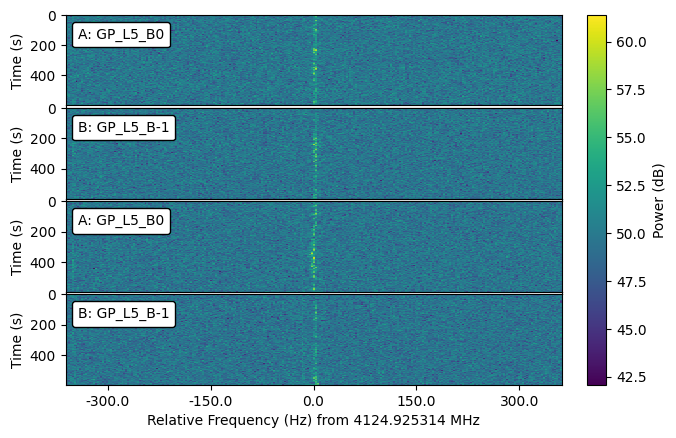

TopHitNum                                                                             5140
DriftRate                                                                         0.004373
SNR                                                                             424.637756
Uncorrected_Frequency                                                          3947.537399
Corrected_Frequency                                                            3947.537399
ChanIndx                                                                             77491
FreqStart                                                                      3947.550179
FreqEnd                                                                        3947.524622
SEFD                                                                                   0.0
SEFD_freq                                                                              0.0
CoarseChanNum                                                                           61

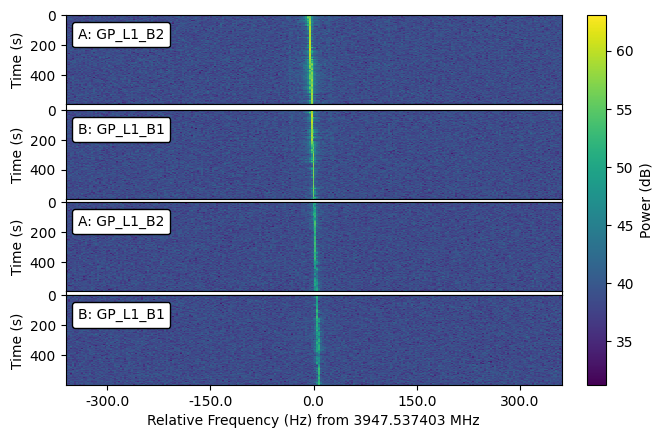

TopHitNum                                                                              1204
DriftRate                                                                          0.004373
SNR                                                                               10.301322
Uncorrected_Frequency                                                           3946.530858
Corrected_Frequency                                                             3946.530858
ChanIndx                                                                             437746
FreqStart                                                                       3946.543638
FreqEnd                                                                         3946.518081
SEFD                                                                                    0.0
SEFD_freq                                                                               0.0
CoarseChanNum                                                                   

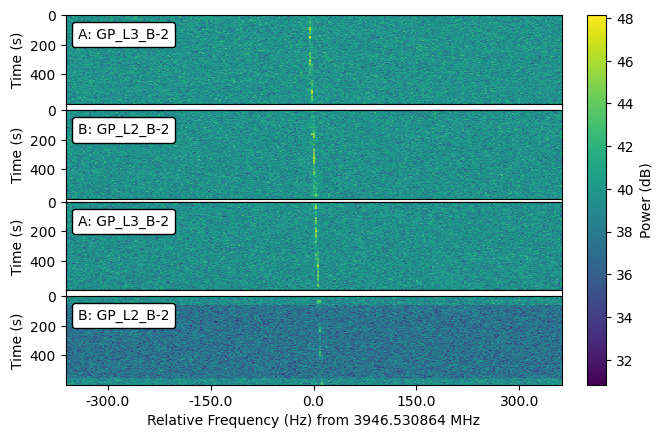

In [9]:
example_info = [
    ['blc65', 'DIAG_SCINT_GP_L5_B0_0012', 5688, 0, 256],
    ['blc76', 'DIAG_SCINT_GP_L1_B1_0035', 9904, 1, 256],
    ['blc75', 'DIAG_SCINT_GP_L3_B-2_0009', 4531, 0, 256],
]

for info in example_info:
    node, target, idx, pointing_idx, fchans = info 

    
    for dsc in cadence_list:
        if target[:-5] in str(dsc):
            break 
    print(dsc[pointing_idx].hits.loc[idx])

    c = dsc_cadence(dsc, pointing_idx, int(idx), fchans)
    for fr in c:
        fr.source_name = fr.source_name[11:]
    
    c.plot(slew_times=True)
    plt.savefig(FIGURES_DIR / f'scint_examples_{node}_{target}_{idx}.pdf', bbox_inches='tight')
    plt.show()

In [19]:
kderanker_1e4.all_dfs['mle_rank'].min()

0.00863595626166894

In [21]:
sum(kderanker_1e4.all_dfs['mle_rank'] > 0.01) / len(kderanker_1e4.all_dfs['mle_rank'])

0.9985

In [23]:
sum(kderanker_1e4.all_dfs['mle_rank'] >= 0.00863595626166894) / len(kderanker_1e4.all_dfs['mle_rank'])

1.0

In [24]:
sum(df_events['mle_rank'] >= 0.00863595626166894) / len(df_events['mle_rank'])

0.3036723163841808

In [25]:
sum(df_events['mle_rank'] >= 0.0086) / len(df_events['mle_rank'])

0.3038384845463609